In [1]:
import numpy as np
from numpy import random
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Custom Loss Functions for Fuel Moisture Models

*Author:* Jonathon Hirschi

[Fuel moisture content](https://www.ncei.noaa.gov/access/monitoring/dyk/deadfuelmoisture) is a measure of the water content of burnable materials. A loss function is intended to measure the fitting accuracy of a statistical model.

The purpose of this notebook is to discuss training fuel moisture models with various loss functions to try to account for the nonlinear effect of fuel moisture on wildfire rate of spread.

## Example with Weighted Least Squares

To illustrate the effect of changing loss functions, consider a simple linear model with one predictor for $n$ samples:

$$f(x_i, \pmb\beta) = \beta_0 + \beta_1 x_i, \text{ for }i=1,..., n$$

Ordinary least squares (OLS) is the most basic method of estimating the $\beta$ parameter values. The method minimizes the residual sum of squares (RSS), the loss function in this case. Equal weight is given to each residual value in the loss function,

$$r_i = y_i - f(x_i, \pmb \beta)$$

$$\pmb{\hat\beta_{OLS}} = argmin_\beta \sum_{i=1}^n r_i^2$$

Weighted least squares minimizes the weighted residual sum of squares, with a weight $w_i$ applied to each residual value. In principle, the weights could from from anywhere. 

$$\pmb{\hat\beta_{W}} = argmin_\beta \sum_{i=1}^n w_ir_i^2$$

In the following example, the OLS model for simulated data is compared to two different weighting schemes. In both cases, the weights come from normal distributions centered at the observed mean of the response value, but one has a large variance and the other has a much smaller variance. In this formulation of weights, as the variance of the normal distribution increases, the resulting model parameters approach the OLS parameters. 

In [2]:
# Simulate Data
random.seed(123)
npts = 200
x = np.linspace(0, 100, npts)

y = 100+x+random.normal(0, 10, npts)

In [3]:
# Fit OLS model
xx = x.reshape(len(x), 1)
w1 = np.ones(len(x)) # adding weights of 1 for illustrative purposes
model1 = LinearRegression().fit(xx, y, w1)
preds1 = model1.predict(xx)

In [4]:
# Set up weighting distributions
m = np.floor(np.mean(y)) # center weights at central tendency of response data 
s = np.std(y)
rv = norm(loc=m, scale = s/2) 
rv2 = norm(loc=m, scale = 1) # extreme weight distribution for illustrative purposes

In [5]:
# Fit Weighted LS
w2 = rv.pdf(y)
model2 = LinearRegression().fit(xx, y, w2)
preds2 = model2.predict(xx)

w3 = rv2.pdf(y)
model3 = LinearRegression().fit(xx, y, w3)
preds3 = model3.predict(xx)

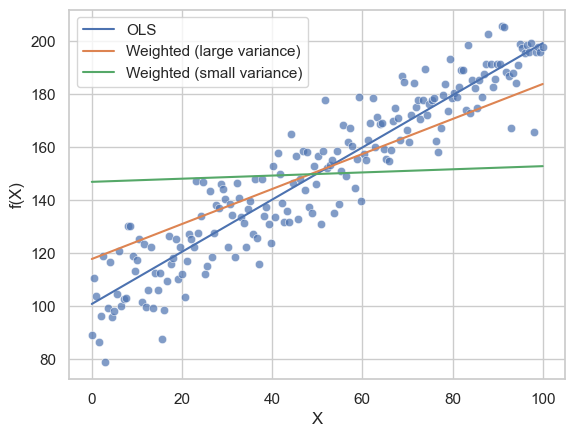

In [6]:
# Plot regression lines
sns.set(style='whitegrid')
p=sns.lineplot(x=x, y=preds1, label="OLS")
p=p.set(xlabel="X", ylabel="f(X)")
sns.lineplot(x=x, y=preds2, label = "Weighted (large variance)")
sns.lineplot(x=x, y=preds3, label = "Weighted (small variance)")
sns.scatterplot(x=x, y=y, alpha=.7)
plt.legend()

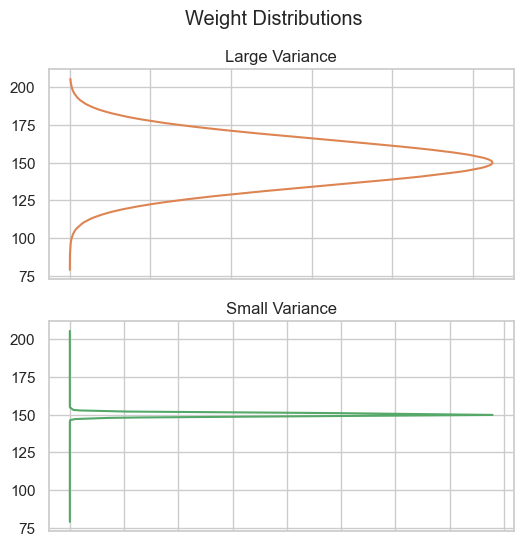

In [7]:
# Plot Weighting Distriubtions
yy = np.sort(y)
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6))
fig.suptitle('Weight Distributions')
ax1.plot(rv.pdf(yy), yy, color=sns.color_palette()[1])
ax1.set_title("Large Variance")
ax1.set_xticklabels([]);
# ax1.set_yticklabels([]);
ax2.plot(rv2.pdf(yy), yy, color=sns.color_palette()[2])
ax2.set_title("Small Variance")
ax2.set_xticklabels([]);
# ax2.set_yticklabels([]);
# plt.show

The weighted least squares model with the small variance (green line) gives tiny weight to residuals far away from the sample mean of the response.

## Fuel Moisture Nonlinear Effect on Rate of Spread

[Rate of spread](https://www.nwcg.gov/course/ffm/fire-behavior/83-rate-of-spread#:~:text=The%20rate%20of%20spread%20is,origin%20quickly%20with%20great%20intensity.) (ROS) is a measure of the speed a fire moves (often units of m/s). The following image shows the nonlinear relationship between FMC and ROS at a single spatial location, while holding other variables associated with ROS constant. Wildfire spreads most readily in dry fuels, as seen in the peak of the ROS curve at zero FMC. The ROS drops off quickly as fuels get wetter, but then it levels off until the ROS is zero, or when the FMC reaches the "extinction value". 

![](https://wiki.openwfm.org/mediawiki/images/9/9b/Grass-fmc.png)

If the goal of training fuel moisture models is to get more accurate forecasts of wildfire ROS, it is intuitive that models should be trained directly on ROS. Instead of using loss functions on FMC, why not cut out the middleman and construct a loss function directly with ROS? The issue with that approach comes from following two facts:

1. FMC is highly correlated in time.
2. ROS reaches extinction value relatively quickly for dead fuels.

Since fuel moisture content is the "percent of the dry weight of that specific fuel" ([from NOAA](https://www.ncei.noaa.gov/access/monitoring/dyk/deadfuelmoisture#:~:text=Fuel%20moisture%20is%20a%20measure,content%20would%20be%20zero%20percent.)), this value can easily go over 100% for very wet fuels, since the water content can weight more than the underlying burnable material. The extinction value for tall grass, depicted above, reaches its extinction moisture value at roughly 25%. Thus, the ROS for tall grass with 25% FMC would be the same as that of tall grass with 150% FMC. In both cases, the ROS would be zero. 

This fact combines with the temporal correlation of FMC to make it potentially undesirable to train FMC models directly on ROS. Consider a case when the true FMC content was 30% for tall grass. Model 1 predicts 25% FMC and Model 2 predicts 150%. Both models would receive a loss of zero for that prediction, since both models predict zero ROS which matches the observed value. However, if atmospheric conditions led to the fuel drying out over time, the models would predict very different ROS within a few hours. Fuels with an FMC of 25% would dry out relatively quickly compared to fuels with an FMC of 150%, and thus the ROS would be nonzero in the former case much quicker than the latter. 

### Simulated FMC Example

Fuel moisture content has a cyclical pattern that corresponds to a 24 hour day, where there are cycles throughout the day of temperature and relative humidity (two of the main theoretical drivers of FMC). For this example, we simulate a sinusoidal curve with a decreasing linear trend.

In [22]:
# Sim data, no rain for simplicity
random.seed(456)

from data_funcs import synthetic_data
hours = 400 # Total number of time steps
dat = synthetic_data(max_rain = 0, data_noise = .2)  # Sim data from FMDA project code
fm = dat['fm'][0:hours]

# Manually edit sim data to illustrate point about ROS
fm = fm + 20 - .07*np.arange(0, hours) # Shift up by 20, add decreasing trend

Text(0, 0.5, 'FMC (%)')

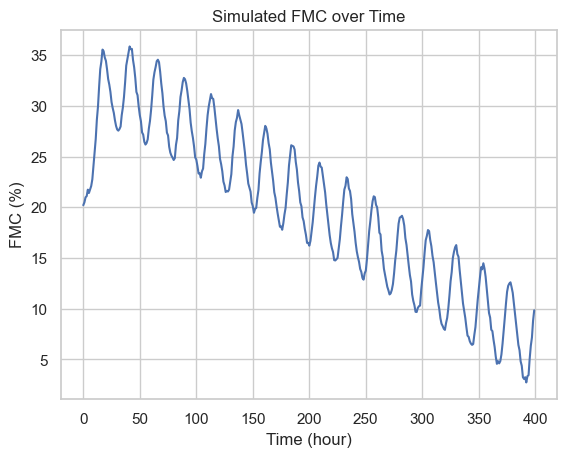

In [23]:
h=np.arange(0, hours)
plt.plot(h, fm)
plt.title("Simulated FMC over Time")
plt.xlabel("Time (hour)")
plt.ylabel("FMC (%)")

We then construct an idealized rate of spread curve from the source above. *Note:* an extinction moisture of about 25 is common for various fuel types.

Text(0.5, 1.0, 'ROS Curve')

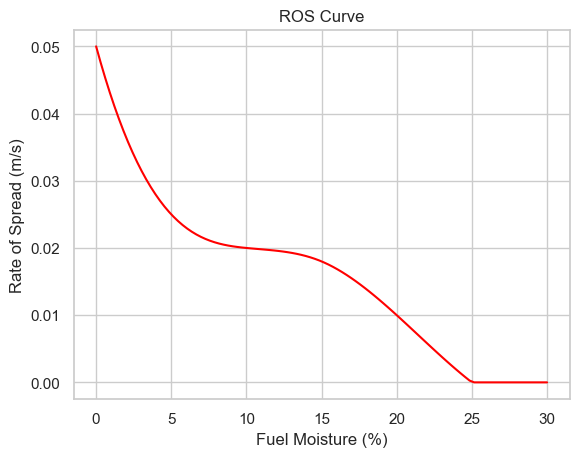

In [24]:
# Construct Idealized ROS curve
x = np.array([0, 5, 10, 15, 20, 25])
y = np.array([.05, .025, .02, .018, .01, 0])
from scipy.interpolate import CubicSpline
xvals = np.linspace(start=0, stop=30, num=100)

ros_f = CubicSpline(x, y)
def ros(fm):
    r = ros_f(fm)
    r[fm>25]=0
    return r



plt.plot(xvals, ros(xvals), "red")
plt.xlabel("Fuel Moisture (%)")
plt.ylabel("Rate of Spread (m/s)")
plt.title("ROS Curve")

Text(0.5, 1.0, 'ROS over Time')

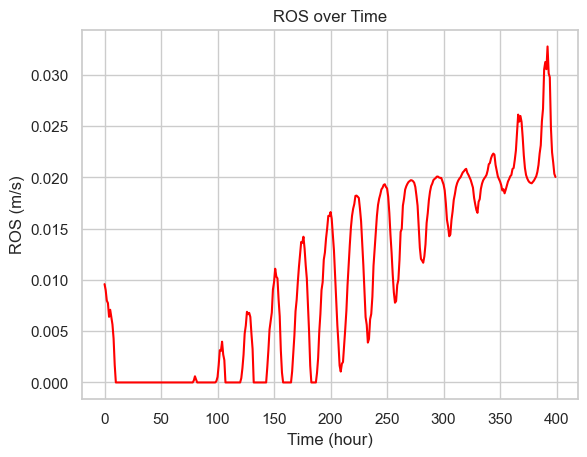

In [25]:
# Plot ROS over time
rs = ros(fm)
plt.plot(h, rs, "red")
plt.xlabel("Time (hour)")
plt.ylabel("ROS (m/s)")
plt.title("ROS over Time")

We then train 2 simple time series linear models with just hour (0-400) and hour of the day (0-23) as predictors. The training period will be 0-200 hours and the test period will be 201-400 hours.

In [42]:
# Model 1 fit with OLS on FMC
hour_day = np.resize(np.arange(24), hours).reshape(-1, 1) # 0-23 hour
h = h.reshape(-1, 1)
X = np.concatenate((h, hour_day), axis=1)
fmmod1 = LinearRegression().fit(X, fm)
preds1 = fmmod1.predict(X)

Text(325, 32, 'R2=0.902')

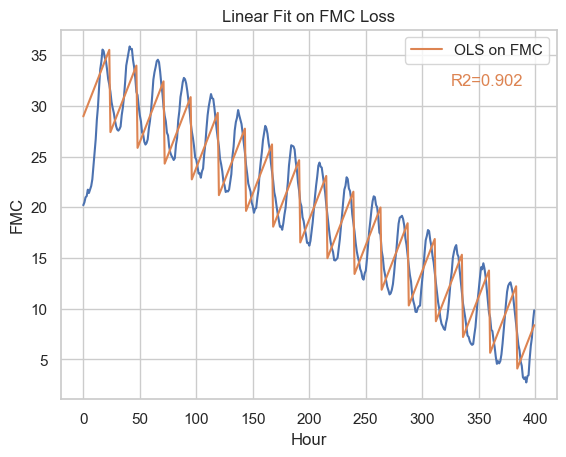

In [41]:
plt.plot(h, fm)
plt.plot(h, preds1, label="OLS on FMC")
plt.legend()
plt.title("Linear Fit on FMC Loss")
plt.xlabel("Hour")
plt.ylabel("FMC")
plt.annotate("R2="+str(np.round(fmmod1.score(X, fm), 3)), [325, 32],
            color=(0.8666666666666667, 0.5176470588235295, 0.3215686274509804))

In [46]:
# Model 2 fit OLS on ROS
hour_day = np.resize(np.arange(24), hours).reshape(-1, 1) # 0-23 hour
h = h.reshape(-1, 1)
X = np.concatenate((h, hour_day), axis=1)
fmmod2 = LinearRegression().fit(X, rs)
preds2 = fmmod2.predict(X)

Text(0, 0.025, 'R2=0.852')

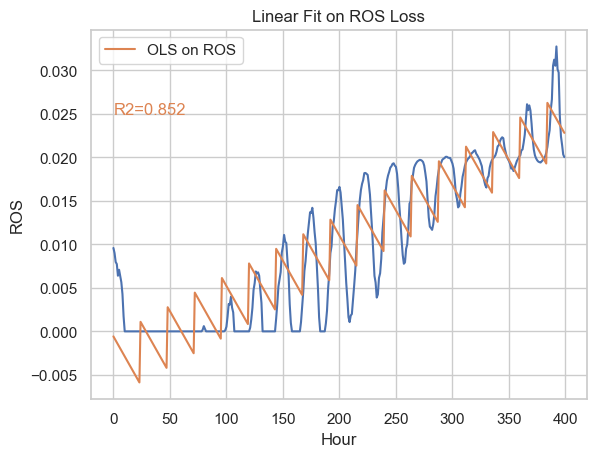

In [53]:
plt.plot(h, rs)
plt.plot(h, preds2, label="OLS on ROS")
plt.legend()
plt.title("Linear Fit on ROS Loss")
plt.xlabel("Hour")
plt.ylabel("ROS")
plt.annotate("R2="+str(np.round(fmmod2.score(X, rs), 3)), [0, .025],
            color=(0.8666666666666667, 0.5176470588235295, 0.3215686274509804))

## Proposed Experiment

My research hypothesis is that a weighted loss function for training fuel moisture models, which places more weight on lower values of FMC, will result in more accurate ROS forecast than either an unweighted loss function on FMC or a loss function directly on ROS. The weighting scheme is intended to assign a larger loss to model errors for low values of fuel moisture, since small errors in FMC in that range lead to large differences in ROS. The fully realized version of this project would compare ROS forecasts to real observed fires with various fuel types. For a Masters' Project, I will consider the theoretical ROS at single spatial locations with only 10-hour dead fuel moisture (fm10). The fuel moisture models will be evaluated by their ROS forecast accuracy. Additionally, I need to specify spatial and temporal domains for analysis that are necessarily somewhat arbitrary. To test my hypothesis in the simplified framework, I propose the following experimental design. 

1. Build a Testing Dataset:

**Spatial Frame**: Collect hourly fm10 observations for all RAWS stations in Colorado with complete data to run fuel moisture models (46 in total). 

**Time Frame**: Collect fm10 observations from May through September, corresponding to the Colorado Wildfire Season as defined by the [Western Fire Chiefs Association](https://wfca.com/articles/colorado-fire-season/). These time periods will be divided into 5 periods of training and testing, one for each month. The **training period** will be days 1-20 of each month, and the **testing period** will be days 21-30 or 31 of each month.

This will result in a dataset for 225 potential model runs (46 stations times 5 time periods).

2. Define a set of Fuel Moisture Models:

I will consider a few different models to examine how changing the loss function changes the ROS forecast accuracy:

* Simple Linear Regression Model: Including all FMC variables as predictors. I include this because it will be simple to construct and deploy and analyze how it interacts with different loss functions.
* Auto-regressive Linear Model: The only predictor will be the 1 hour time lag of FMC. I developed such a model for Data 2 Policy, which showed relatively strong accuracy. I include it to investigate how the loss functions interact with a time-series based model.
* Physics-Initiated Recurrent Neural Network: This model was developed by Jan Mandel and it is part of my ongoing research to assist him with developing this model.

3. Build a set of Candidate Loss Functions:

* Unweighted RSS on FMC. This would be one loss function.
* Unweigthted RSS on ROS. This would also be one loss function.
* Weighted RSS on FMC. This would be a set of loss functions. I will consider Gamma distributions with various parameter pairs. I select Gamma distributions a priori: they have positive support (FMC cannot be negative) and they are flexible to get different shapes of the resulting distributions.

My hypothesis is that some loss function from the third set of loss functions will lead to the best forecasts of ROS.           

4. Fit the models and forecast ROS:

For each model and each loss function, train the model on 20 days of data, for the spatial locations I describe above, and forecast ROS 10 days into the future.

5. Evaluate Forecast Accuracy:

For each model run, calculate the accuracy of the ROS forecast by calculating the root mean squared error (RMSE) of the resulting ROS predictions. I will then summarize the average RMSE at each location and time period. Following that, I will analyze whether there were systematic differences between the different FMC models, e.g. whether one loss function work better for the RNN than for the linear regression.

## References

* Open Wildland Fire Modeling E Community. https://wiki.openwfm.org/wiki/
* National Wildfire Coordinating Group (NWCG). https://www.nwcg.gov/course/ffm/
* *Dead Fuel Moisture*, NOAA National Centers for Environmental Information. https://www.ncei.noaa.gov/access/monitoring/dyk/deadfuelmoisture